## Data pre-processing and augmentation

In [126]:
from __future__ import print_function, division
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import os
%matplotlib inline 

import matplotlib.pyplot as plt
from PIL import Image
from ipywidgets import interact
from scipy.misc import imresize, imsave
from shutil import copyfile

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
import random


## Initialization

In [127]:
# image dimension of the input images
img_width, img_height = 150, 150

# Download the data from Kaggle https://www.kaggle.com/c/dogs-vs-cats/data?train.zip
# One can do it from CLI using Curl 
## e.g. 1. wget -x -c --load-cookies cookies.txt -nH --cut-dirs=5 https://www.kaggle.com/c/dogs-vs-cats/download/train.zip
##      2. create train and validation folders and respectively unzip the downloaded files
train_data_dir = 'data/dogs_vs_cats/train'
validation_data_dir = 'data/dogs_vs_cats/validation'

# Experiment initialization:
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [128]:
from random import randint
def browse_images(dir_path, define_range=10):
    list_of_images = os.listdir(dir_path)
    n = len(list_of_images)
    if define_range > n:
        raise ValueError("out of range")
    def view_image(index):
        im = Image.open('{}{}'.format(dir_path, list_of_images[index]))
        plt.imshow(im, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
    interact(view_image, index=(0, define_range))

# Quick Exploration of the images

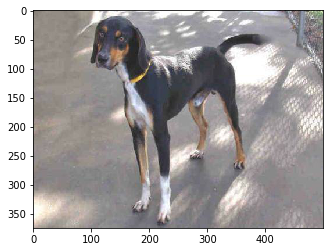

In [129]:
# Explore the dog pictures
browse_images('data/dogs_vs_cats/train/dog/')

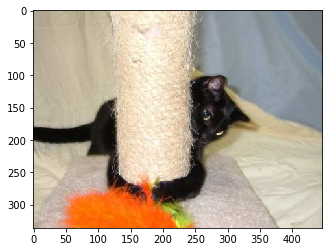

In [130]:
# Explore the cat pictures
browse_images('data/dogs_vs_cats/train/cat/')

## Selecting Backend - Tensorflow or Theano

In [102]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

In [131]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/dogs_vs_cats/train/cat/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)
x.shape

(374, 500, 3)

In [132]:
x = x.reshape((1,) + x.shape)
print(x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/dogs_vs_cats/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

(1, 374, 500, 3)


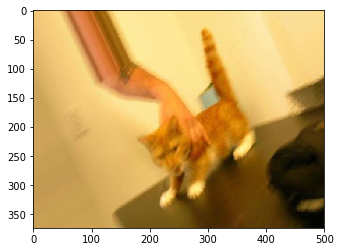

In [105]:
browse_images('data/dogs_vs_cats/preview/')

## Model Architecture

In [109]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Data pre-processing

In [91]:
#TODO: Stream-line splitting of train and test in a better way
_image_list_dog = os.listdir('data/dogs_vs_cats/train/dog/')
image_index_list_dog = random.sample(range(len(_image_list_dog)), k=2500)
os.mkdir('data/dogs_vs_cats/train/training_set/dog', 0755 )
os.mkdir('data/dogs_vs_cats/train/validation_set/dog', 0755 )

_image_list_cat = os.listdir('data/dogs_vs_cats/train/cat/')
image_index_list_cat = random.sample(range(len(_image_list_cat)), k=2500)
os.mkdir('data/dogs_vs_cats/train/training_set/cat', 0755 )
os.mkdir('data/dogs_vs_cats/train/validation_set/cat', 0755 )

In [92]:
train_test_split = 0.8
train_split = int(train_test_split*2500)
test_split = int(train_test_split*2500)
image_index_list_dog_train, image_index_list_dog_test = image_index_list_dog[:train_split], image_index_list_dog[train_split:]
image_index_list_cat_train, image_index_list_cat_test = image_index_list_cat[:train_split], image_index_list_cat[train_split:]

In [93]:
def copy_files(image_index_list, file_list, src, dst):
    for index in image_index_list:
        image_name = file_list[index]
        src_path = os.path.join(os.getcwd(),src, image_name)
        dst_path = os.path.join(os.getcwd(), dst, image_name)
        copyfile(src_path, dst_path)

In [94]:
# Training set 
copy_files(image_index_list_dog_train, _image_list_dog, src='data/dogs_vs_cats/train/dog/', 
           dst='data/dogs_vs_cats/train/training_set/dog/')
copy_files(image_index_list_cat_train, _image_list_cat, src='data/dogs_vs_cats/train/cat/', 
           dst='data/dogs_vs_cats/train/training_set/cat/')

# Testing set
copy_files(image_index_list_dog_test, _image_list_dog, src='data/dogs_vs_cats/train/dog/', 
           dst='data/dogs_vs_cats/train/validation_set/dog/')
copy_files(image_index_list_cat_test, _image_list_cat, src='data/dogs_vs_cats/train/cat/', 
           dst='data/dogs_vs_cats/train/validation_set/cat/')

In [107]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'data/dogs_vs_cats/train/training_set/',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        'data/dogs_vs_cats/train/validation_set/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model Training

In [110]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 41s - loss: 0.7090 - acc: 0.5180 - val_loss: 0.7352 - val_acc: 0.5138
Epoch 2/50
125/125 [==============================] - 41s - loss: 0.6881 - acc: 0.5525 - val_loss: 0.6584 - val_acc: 0.6515
Epoch 3/50
125/125 [==============================] - 41s - loss: 0.6611 - acc: 0.6360 - val_loss: 0.6305 - val_acc: 0.6263
Epoch 4/50
125/125 [==============================] - 41s - loss: 0.6395 - acc: 0.6465 - val_loss: 0.5934 - val_acc: 0.6578
Epoch 5/50
125/125 [==============================] - 41s - loss: 0.6038 - acc: 0.6965 - val_loss: 0.5779 - val_acc: 0.6919
Epoch 6/50
125/125 [==============================] - 41s - loss: 0.6126 - acc: 0.6830 - val_loss: 0.5564 - val_acc: 0.7121
Epoch 7/50
125/125 [==============================] - 41s - loss: 0.6079 - acc: 0.6840 - val_loss: 0.5552 - val_acc: 0.7096
Epoch 8/50
125/125 [==============================] - 41s - loss: 0.5712 - acc: 0.7125 - val_loss: 0.5201 - val_acc: 0.7386
Epoch 9/

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [115]:
model.save_weights('a_simple_model.h5')

## Interpreting the Model 

In [117]:
from skater.core.local_interpretation.lime.lime_image import LimeImageExplainer
from skater.model import InMemoryModel

(1, 150, 150, 3)


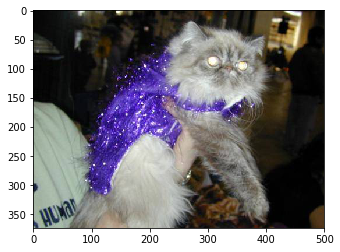

In [169]:
img = load_img('data/dogs_vs_cats/train/training_set/cat/cat.10013.jpg')
# actual image
plt.imshow(img)
img_as_arry = img_to_array(img)
resized = imresize(img_as_arry, (img_width, img_height))
an_img = resized.reshape((1,) + resized.shape)
print(an_img.shape)

In [170]:
predict_img = model.predict_proba(an_img)
print('1: dog; 0: cat')
print(predict_img)
# we have an incorrect predict, now lets investigate why this happenend ?

1/1 [==============================] - 0s
1: dog; 0: cat
[[ 1.]]
